In [33]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
import qiskit.quantum_info as qi
from numpy import pi, random, sqrt
import numpy as np
from qiskit.quantum_info import Statevector, Operator

In [34]:
state = QuantumRegister(5, name="|ψ>")

circuit = QuantumCircuit(state)
"""
circuit.u(theta = random.random() * 2 * pi,
    phi = random.random() * 2 * pi,
    lam = random.random() * 2 * pi,
    qubit = state[0])
"""
circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, '|ψ>'), 0), Qubit(QuantumRegister(5, '|ψ>'), 1), Qubit(QuantumRegister(5, '|ψ>'), 2), Qubit(QuantumRegister(5, '|ψ>'), 3), Qubit(QuantumRegister(5, '|ψ>'), 4)), clbits=())

Encoding

In [35]:
encoding = QuantumCircuit(5)

circuit.z(state[0])

encoding.h([1])
encoding.cz([1], [2, 4])
encoding.cx([1], [0])

encoding.barrier()

encoding.h([4])
encoding.cz([4], [1, 3])
encoding.cx([4], [0])

encoding.barrier()

encoding.h([3])
encoding.cz([3], [0, 2])
encoding.cx([3], [4])

encoding.barrier()

encoding.h([2])
encoding.cz([2], [1, 4])
encoding.cx([2], [3])

decoding = encoding.inverse()


In [36]:
circuit = circuit.compose(encoding, qubits=state)

Random Error generation

In [37]:
p_I_x = 0.9
p_I_z = 0.9
circuit.barrier()
def error_gate_x(qubit):
    rand_num = random.random()
    if rand_num >= p_I_x:
        circuit.x(qubit)

def error_gate_z(qubit):
    rand_num = random.random()
    if rand_num >= p_I_z:
        circuit.z(qubit)

for i in state:
    error_gate_x(i)
    error_gate_z(i)


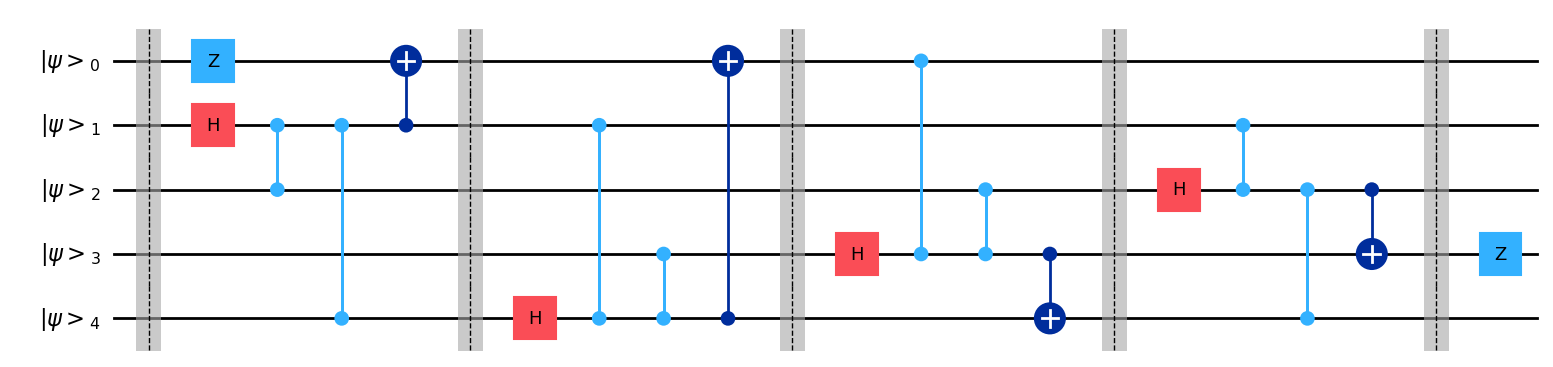

In [38]:
display(circuit.draw(output='mpl'))

In [39]:
ancilla = QuantumRegister(4, name="A")

syndrome = ClassicalRegister(4, name="S")

circuit.add_register(ancilla)
circuit.add_register(syndrome)

In [40]:
circuit.barrier()
circuit.h(ancilla)

i,j = 2,3
m,n = 1,4

for k in range(4):
    circuit.cx(ancilla[k], [state[i % len(state)], state[j % len(state)]])
    circuit.cz(ancilla[k], [state[m % len(state)], state[n % len(state)]])
    i,j,m,n = i+1,j+1,m+1,n+1
    circuit.barrier()

circuit.h(ancilla)
circuit.measure(ancilla, syndrome)


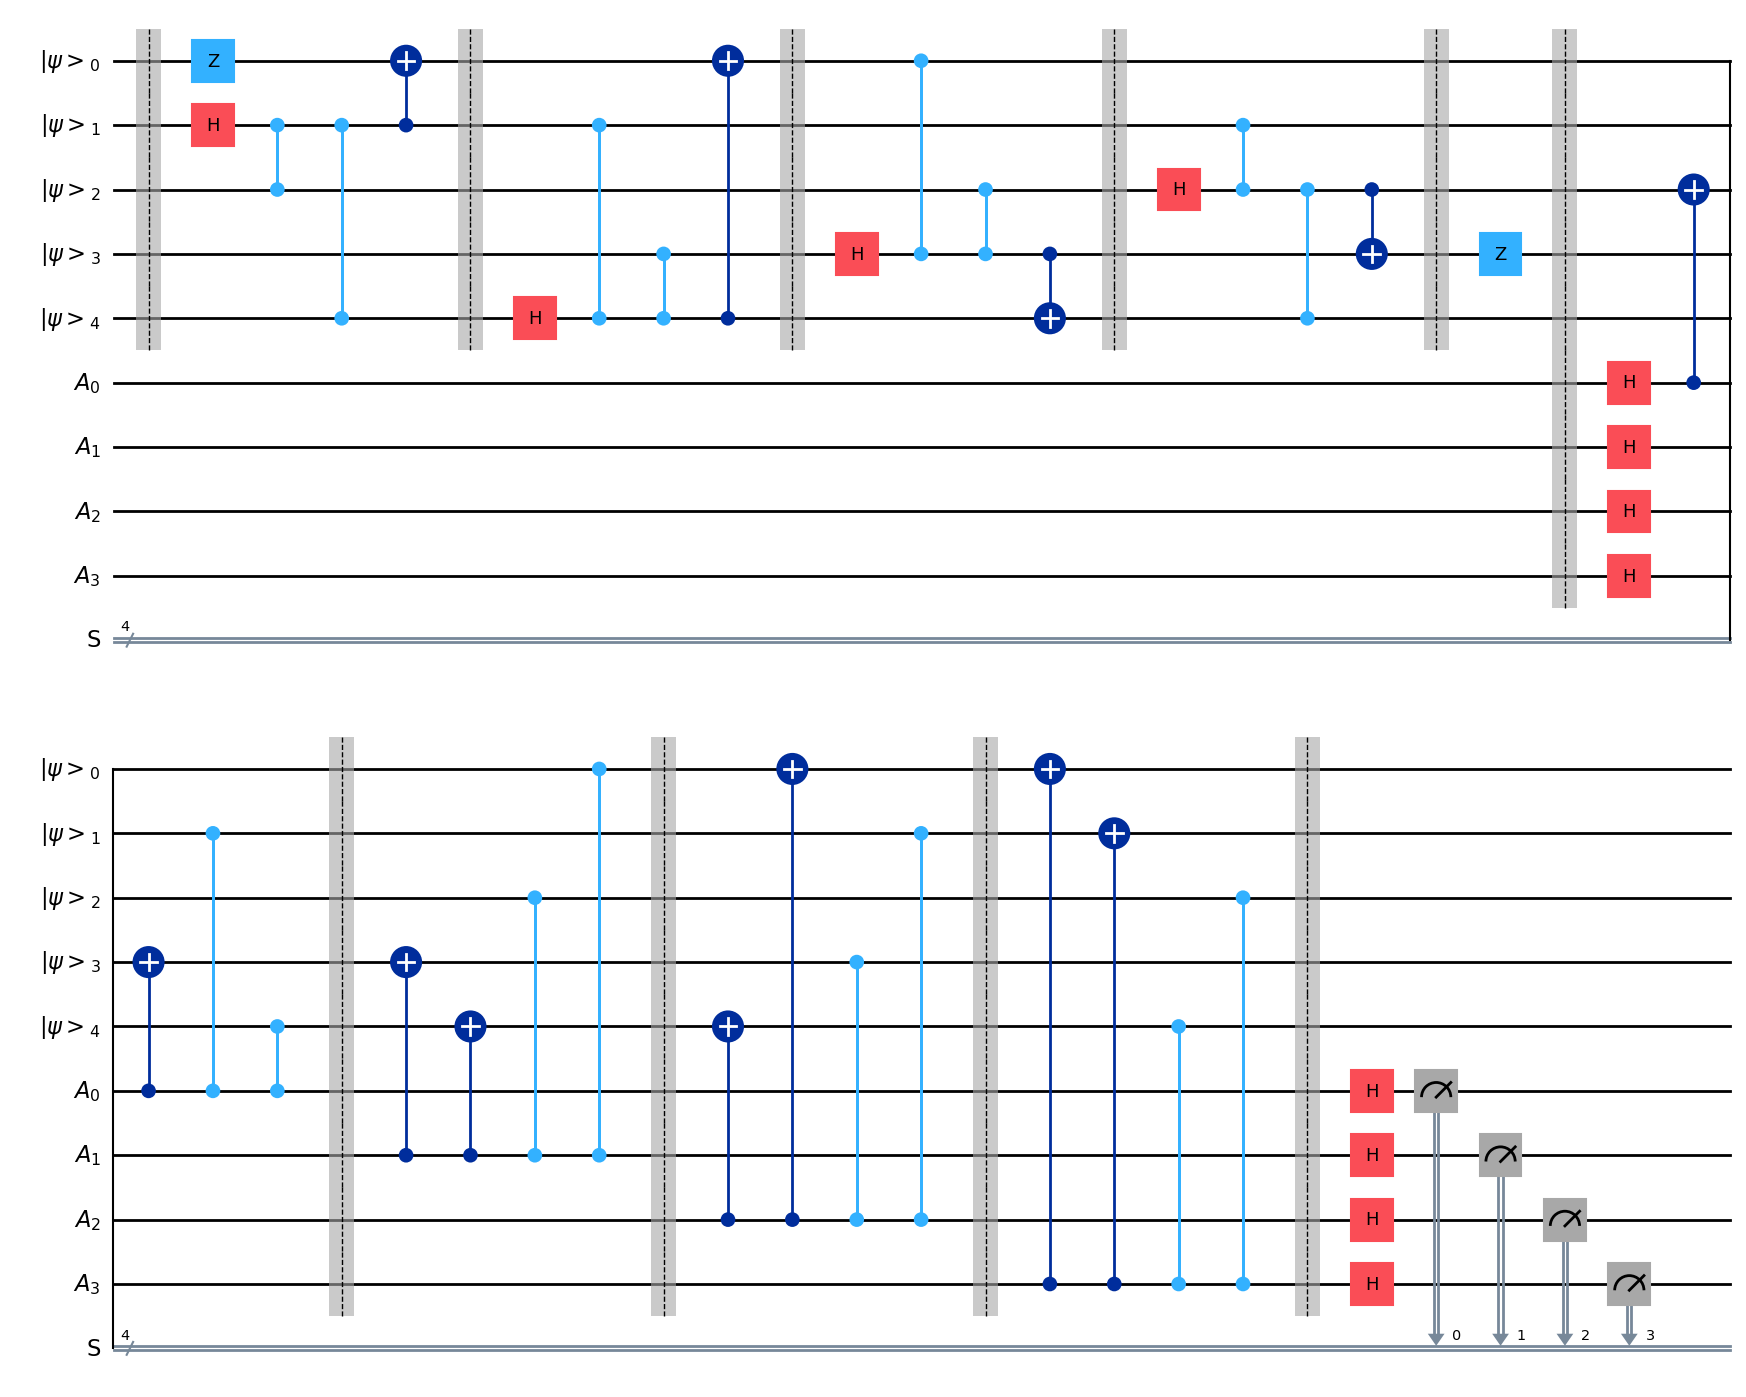

In [41]:
display(circuit.draw(output='mpl'))

In [42]:
result = AerSimulator().run(circuit).result()
statistics = result.get_counts()
synd = bin(0)
for k,v in statistics.items():
    print(k)
    synd = k

0011


Syndrome Table:
X0 : 0010
X1 : 0101
X2 : 1010
X3 : 0100
X4 : 1001

Z0 : 1100
Z1 : 1000
Z2 : 0001
Z3 : 0011
Z4 : 0110

Y0 : 1110
Y1 : 1101
Y2 : 1011
Y3 : 0111
Y4 : 1111

Error Correction:

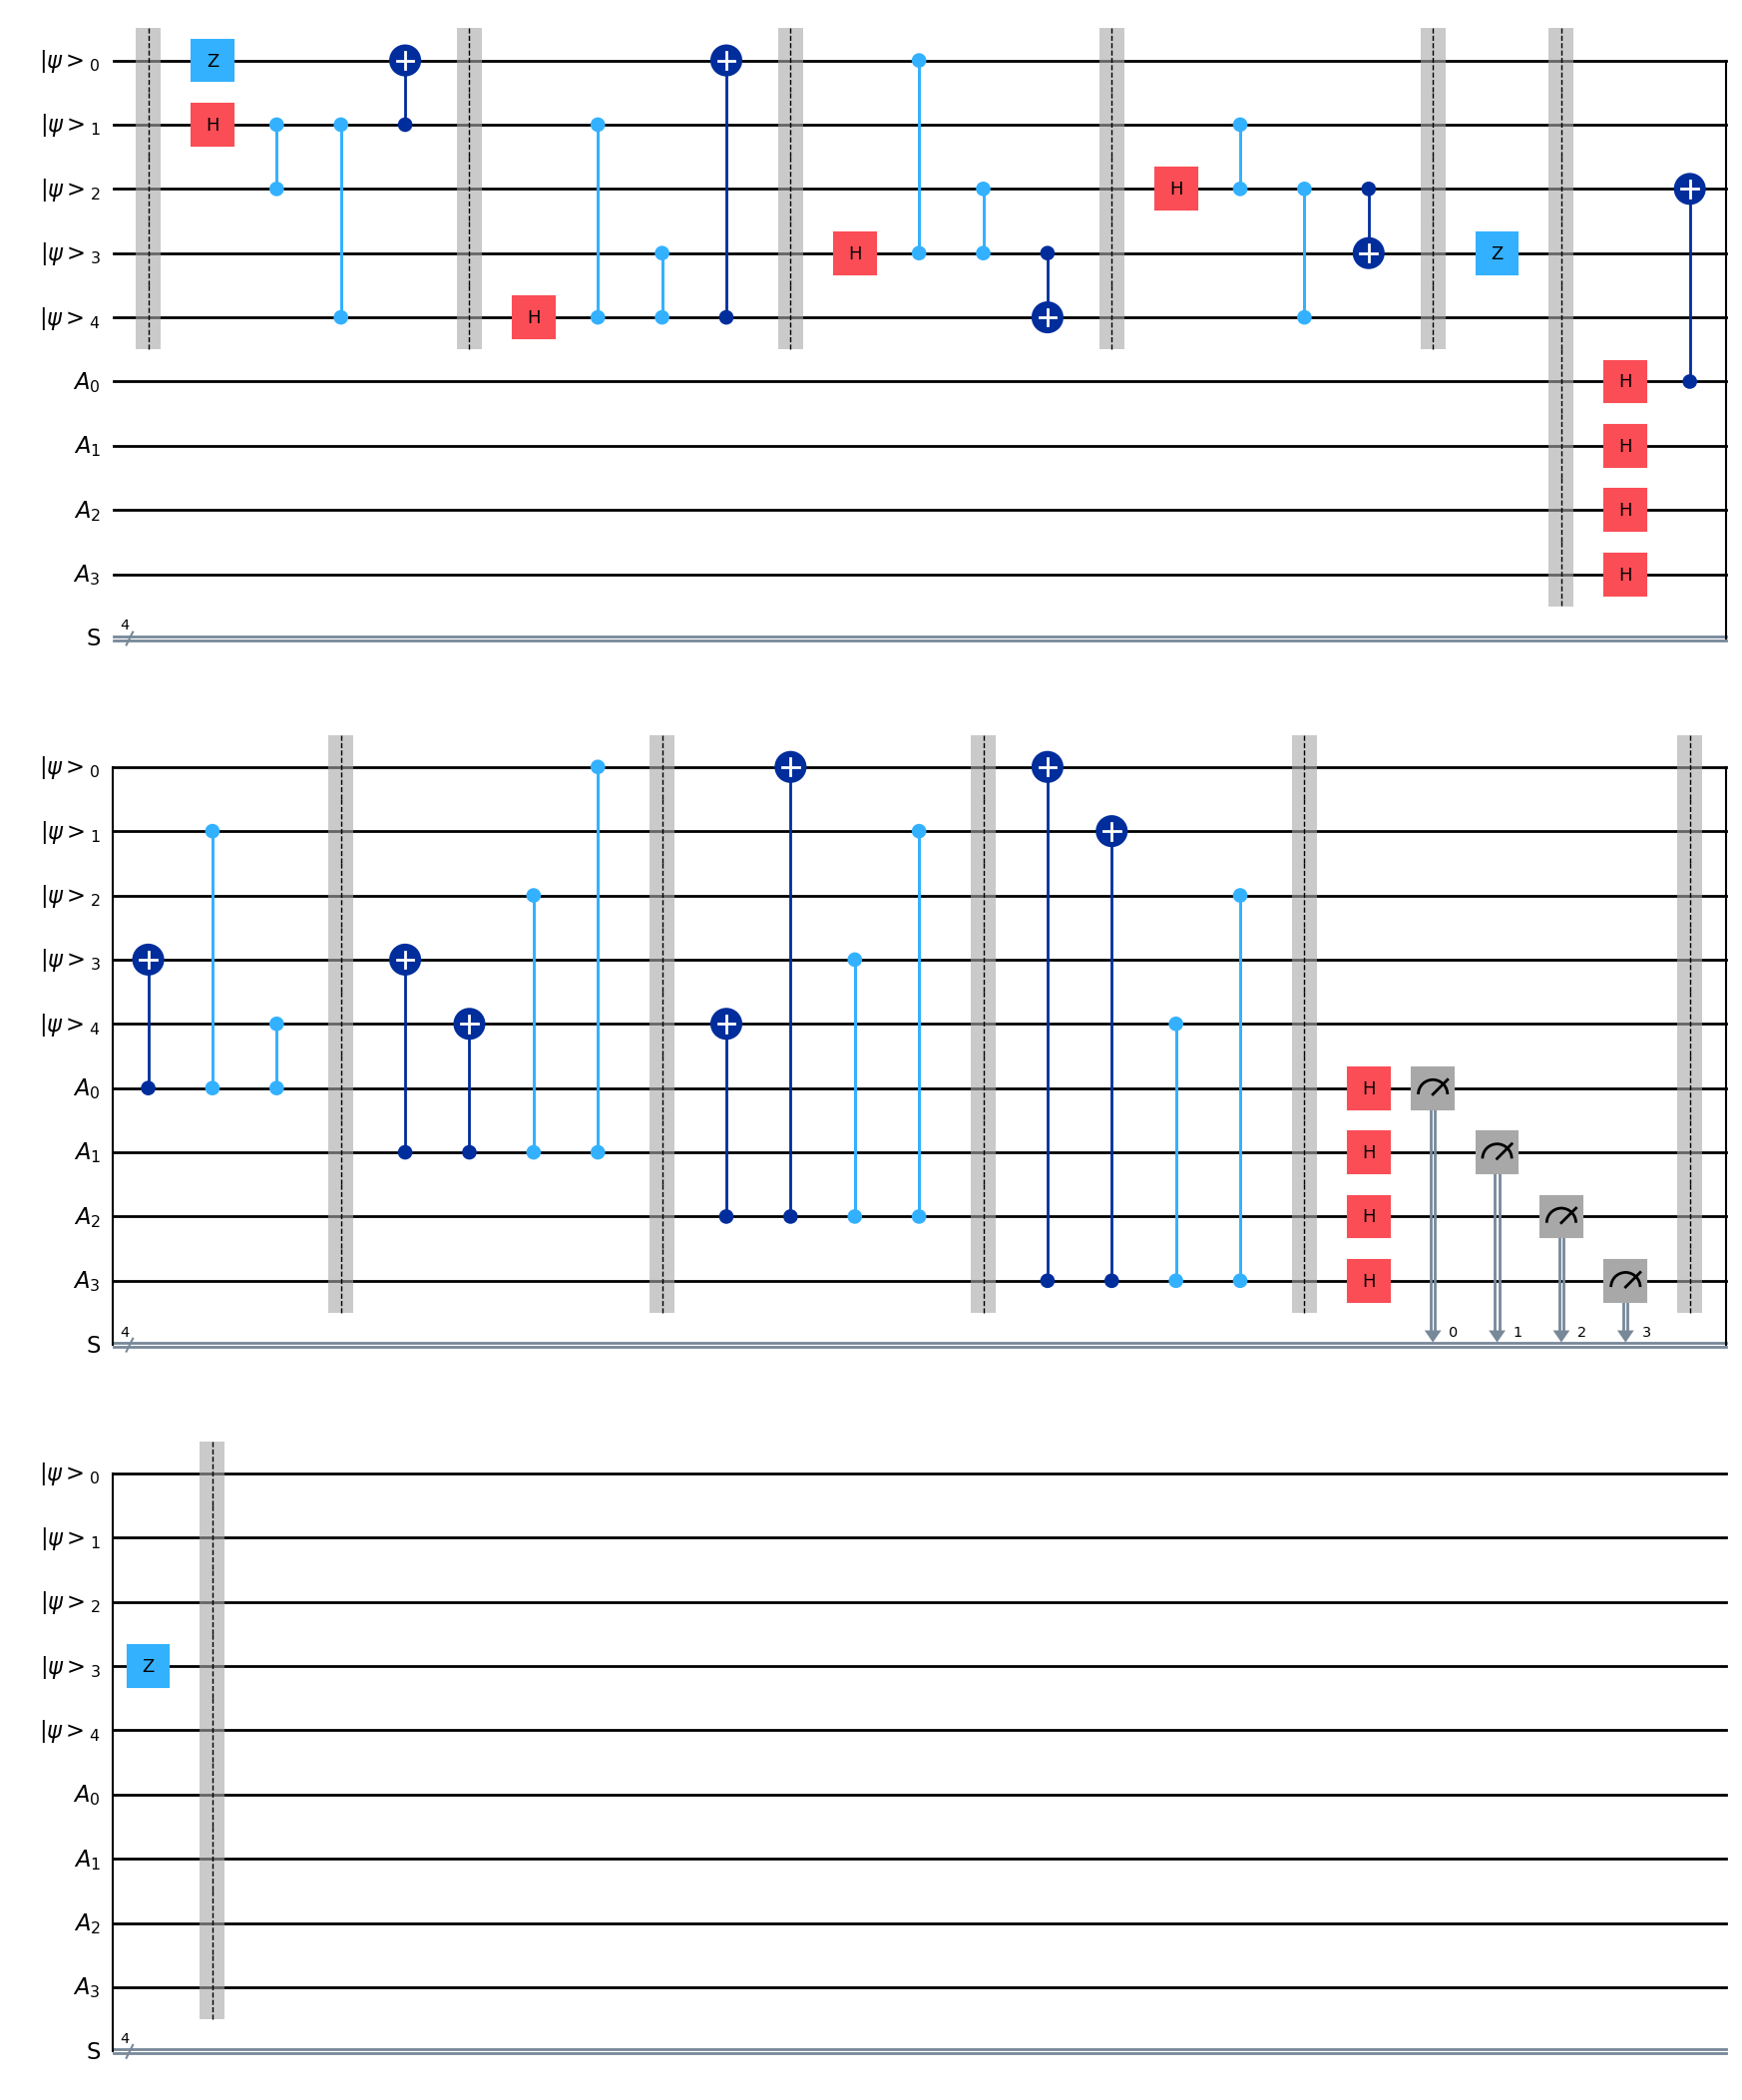

In [43]:
x_list = ['0010', '0101', '1010', '0100', '1001']
z_list = ['1100', '1000', '0001', '0011', '0110']
y_list = ['1110', '1101', '1011', '0111', '1111']
total_list = [x_list, z_list, y_list]

circuit.barrier()

for type, list in enumerate(total_list):
    for index, item in enumerate(list):
        if synd == item:
            if type == 0:
                circuit.x(state[index])
            if type == 1:
                circuit.z(state[index])
            if type == 2:
                circuit.x(state[index])
                circuit.z(state[index])

circuit.barrier()
display(circuit.draw(output='mpl'))

In [44]:
circuit = circuit.compose(decoding, qubits=state)

final_state = ClassicalRegister(1)
circuit.add_register(final_state)
circuit.measure(state[0], final_state)

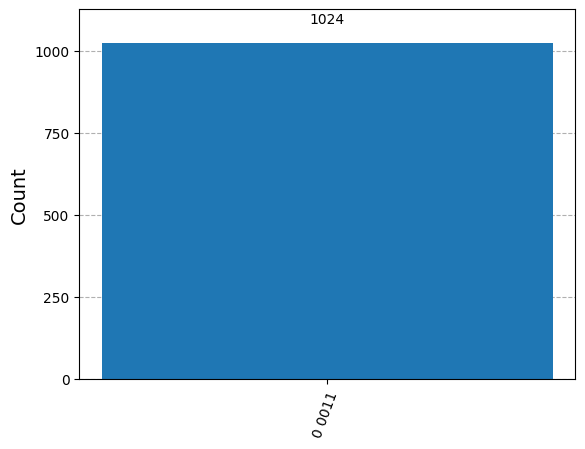

In [45]:
result = AerSimulator().run(circuit).result()
statistics = result.get_counts()
display(plot_histogram(statistics))